# Отток клиентов

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.
 
Необходимо построить модель большим значением *F1*-меры (не ниже 0.59 на тестовой выборке).

Исторические данные о поведении клиентов и расторжении договоров с банком: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных

### Признаки

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

### Целевой признак

- Exited — факт ухода клиента

# 1. Подготовка данных

In [1]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# # будем отображать графики прямо в jupyter'e
# %matplotlib inline
# # #графики в svg выглядят более четкими
# %config InlineBackend.figure_format = 'svg'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import math
from scipy import stats as st

In [3]:
import sys
print(sys.version)

# !pip install scikit-learn==0.21.2

import joblib
print('The joblib version is {}.'.format(joblib.__version__))

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

# _1_
# Классификатор дерева решений
from sklearn.tree import DecisionTreeClassifier
#_2_
# Классификатор случайного леса
from sklearn.ensemble import RandomForestClassifier
#_3_
# Линейная модель
from sklearn.linear_model import LogisticRegression
 
# Оценка правильности
from sklearn.metrics import accuracy_score
# Разделение на тренировочную и валидационную выборку
from sklearn.model_selection import train_test_split
# Средняя квадратичная ошибка
from sklearn.metrics import mean_squared_error
# Оценка качества модели
from sklearn.metrics import classification_report
# Перебор параметров
from sklearn.model_selection import GridSearchCV
# classifier that makes predictions using simple rules
from sklearn.dummy import DummyClassifier

# Encoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
# Среднее гармоническое полноты и точности
from sklearn.metrics import f1_score
#
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
#
from sklearn.utils import shuffle

3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:57:50) 
[GCC 7.5.0]
The joblib version is 0.16.0.
The scikit-learn version is 0.21.2.


In [4]:
# Для оформления 
bold_start = '\033[1m'
yellow = '\033[33m'
red = '\033[31m'
violet = '\033[35m'
blue = '\033[34m'
green = '\033[32m'
green_background = '\033[42m'
red_background = '\033[41m'
bold_end   = '\033[0m'

In [5]:
data = pd.read_csv('/@@@/@@@.csv')

In [6]:
display(data.head())
display(data.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

Tenure имеет пропуски, возможно у данных клиентов нету недвижимости или по каким то причинам данные отсутсвуют

посмотрим повторяются ли такие пользователи

In [7]:
tenure_isna = data[data['Tenure'].isna()]
customerid_tenure_isna = tenure_isna['CustomerId'].value_counts().reset_index()
customerid_tenure_isna[customerid_tenure_isna['CustomerId'] != 1]

,index,CustomerId


Заполним пропуски 0 и приведем столбец к типу int

In [8]:
data['Tenure'].fillna(0, inplace = True)
data['Tenure'] = data.Tenure.astype('Int64')

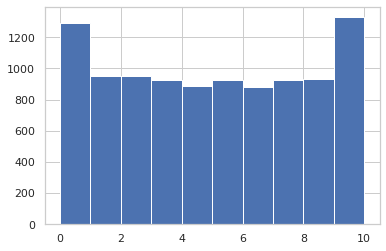

In [9]:
data['Tenure'].hist()

Surname, CustomerId нам вообще не нужны. Привязка к личности никак не поможет изучению наших моделей.
RowNumber тоже уберем

In [10]:
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [11]:
sns.pairplot(data)

In [12]:
data.Gender.value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [13]:
data.loc[:,'Gender'] = (data.Gender == 'Male').astype(int)
data.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


# 2. Исследование задачи

Для оттачивания навыков попробуем три типа кодирования:

1:

In [14]:
OHEcoder = OneHotEncoder()
Geography_ohe = OHEcoder.fit_transform(data[['Geography']]).toarray()
Geography_ohe = pd.DataFrame(Geography_ohe, columns = OHEcoder.categories_[0])
Geography_ohe

,France,Germany,Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
...,...,...,...
9995,1.0,0.0,0.0
9996,1.0,0.0,0.0
9997,1.0,0.0,0.0
9998,0.0,1.0,0.0


In [15]:
Geography_ohe.columns

Index(['France', 'Germany', 'Spain'], dtype='object')

2:

In [16]:
# Прямое кодирование и удаление дамми-ловушки
Geography_dummies = pd.get_dummies(data['Geography'], drop_first=True)
Geography_dummies

,Germany,Spain
0,0,0
1,0,1
2,0,0
3,0,0
4,0,1
...,...,...
9995,0,0
9996,0,0
9997,0,0
9998,1,0


3: OrdinalEncoder лучше для деревьев, поэтому два способа кодирования попадут в data, но потом при обучении модели будут дропаться

In [17]:
# Порядковое кодирование
OEcoder = OrdinalEncoder()
Geography_Ordinal = OEcoder.fit_transform(data[['Geography']])
Geography_Ordinal = pd.DataFrame(Geography_Ordinal, columns=['Geography'])
Geography_Ordinal

,Geography
0,0.0
1,2.0
2,0.0
3,0.0
4,2.0
...,...
9995,0.0
9996,0.0
9997,0.0
9998,1.0


Выполним замену

In [18]:
data.loc[:, 'Geography'] = Geography_Ordinal.loc[:, 'Geography']
data = data.join(Geography_ohe)
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,619,0.0,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,2.0,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0.0,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0.0,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,2.0,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0.0,1,39,5,0.00,2,1,0,96270.64,0,1.0,0.0,0.0
9996,516,0.0,1,35,10,57369.61,1,1,1,101699.77,0,1.0,0.0,0.0
9997,709,0.0,0,36,7,0.00,1,0,1,42085.58,1,1.0,0.0,0.0
9998,772,1.0,1,42,3,75075.31,2,1,0,92888.52,1,0.0,1.0,0.0


---

80% данных на обучение, 10% в тестах и 10% в валидации

In [19]:
features = data.drop(['Exited'], axis = 1)
target = data['Exited']

# организуем равномерное распределение значений обучающего столба 
# при разделении с помощью stratify !

features_train, features_val_test, target_train, target_val_test = train_test_split(features, target,
                                                                                    test_size=0.2, random_state=12345,
                                                                                    stratify=target)

features_valid, features_test, target_valid, target_test = train_test_split(features_val_test, target_val_test,
                                                                            test_size=0.5, random_state=12345,
                                                                            stratify=target_val_test)

features_train.shape, features_val_test.shape, features_valid.shape, features_test.shape

((8000, 13), (2000, 13), (1000, 13), (1000, 13))

In [20]:
 target_train.shape, target_valid.shape, target_test.shape

((8000,), (1000,), (1000,))

In [21]:
features_train_ohe = features_train.drop(['Geography'], axis=1)
features_train_oe = features_train.drop(['Spain','France','Germany'], axis=1)

features_valid_ohe = features_valid.drop(['Geography'], axis=1)
features_valid_oe = features_valid.drop(['Spain','France','Germany'], axis=1)

features_test_ohe = features_test.drop(['Geography'], axis=1)
features_test_oe = features_test.drop(['Spain','France','Germany'], axis=1)

---

# Обучим модель на исходных данных:

In [22]:
#######################################
# _DRY funcion for search in modells_ #
#######################################

def search_in_model2(model, features_train, target_train, features_valid, target_valid):
    best_score = 0
    best_n = 0  
    best_prediction = 0
    for n in range(2, 100):
        # Creating a model by specifying the max_depth=n
        if type(model).__name__ == 'DecisionTreeClassifier':
            model.set_params(max_depth = n)
        elif type(model).__name__ == 'RandomForestClassifier':
            model.set_params(n_estimators = n)
        elif type(model).__name__ == 'LogisticRegression':
            model.set_params(max_iter = n)
        # Training
        model.fit(features_train, target_train)
        # Prediction to estimate the model
        prediction =  model.predict(features_valid)
      
        score = model.score(features_valid, target_valid)
        # Recording the best values
        if score > best_score:
            best_score = score
            best_n = n
            best_prediction = prediction
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]            
    print(green,'best n:' , best_n)
    
    # _funcion for print accuracy_ #
    if best_score < 0.75:
        print( red, "Accuracy:", best_score, bold_end, 
          '\n', bold_start, red_background, "need to update", bold_end)
    else:
        print(green, "Accuracy:", best_score, bold_end, 
          '\n', bold_start, green_background, "OK", bold_end)
    print(blue,
          bold_start,
          'the model quality',
          bold_end, '\n', blue,
          classification_report(target_valid, best_prediction)) 
    
    
    #F1
    f1 = f1_score(target_valid, best_prediction) 
    
    if f1 < 0.59:
        print(red,'f1_score:', f1, bold_end,
              '\n', bold_start, red_background, "need to update", bold_end)
    else:
        print(green,'f1_score:', f1, bold_end,
              '\n', bold_start, green_background, "OK", bold_end)
    #ROC-AUC
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

    plt.figure()

    # building a graph
    plt.plot(fpr, tpr)
    
    # ROC-the curve of a random model (looks like a straight line)
    plt.plot([0, 1], [0, 1], linestyle='--')

    # apply the functions of the plt.slim() and plt.ylim () to
    # set the limits of the axes from 0 to 1
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    # using the PLT.xlabel() and plt.ylabel () functions to
    # sign the axes "false positive speed" and "true positive speed"."
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-curve line')
    
    # header "ROC-curve line" with plt.title() 
    plt.show()
    
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid) 

    print(violet, 'auc_roc:', auc_roc)

 best n: 2
 Accuracy: 0.796  
   OK 
  the model quality  
                precision    recall  f1-score   support

           0       0.80      1.00      0.89       796
           1       0.00      0.00      0.00       204

    accuracy                           0.80      1000
   macro avg       0.40      0.50      0.44      1000
weighted avg       0.63      0.80      0.71      1000

 f1_score: 0.0  
   need to update 


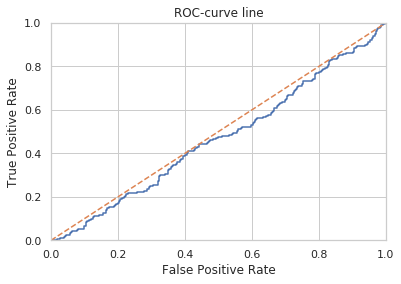

 auc_roc: 0.4671827273623017
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.58 µs


In [23]:
search_in_model2(LogisticRegression(random_state=12345),
                features_train_ohe, target_train, features_valid_ohe, target_valid)
%time

In [24]:
print('target_train:\n',target_train.value_counts(),'target_valid:\n',target_valid.value_counts())

target_train:
 0    6370
1    1630
Name: Exited, dtype: int64 target_valid:
 0    796
1    204
Name: Exited, dtype: int64


score большой за счет большой доли *1* в валидационной выборке. Но *0* вообще не научилась находить 

- ### DecisionTreeClassifier():

Чтобы больше не заниматься перебором и не искать ошибки в вункциях сделаю все с помощью **GridSearchCV**

Зададим параметры для тестирования.

In [25]:
param_grid_dt = {'max_depth':[depth for depth in range(1,15)],
                 'min_samples_split':[split for split in range(2,10,1)],
                 'min_samples_leaf':[leaf for leaf in range(1,10,1)],
                 'random_state': [12345]
                }

Зададим модель.

In [26]:
gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid = param_grid_dt)

Обучим модель для нахождения лучших параметров.

In [27]:
gs_dt.fit(features_train_oe, target_train)
%time

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


Выведем лучшие параметры.

In [28]:
gs_dt.best_params_

{'max_depth': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'random_state': 12345}

Обучим модель с лучшими параметрами.

In [29]:
dt = DecisionTreeClassifier(max_depth =gs_dt.best_params_['max_depth'], 
                            min_samples_leaf =gs_dt.best_params_['min_samples_leaf'],
                            min_samples_split = gs_dt.best_params_['min_samples_split'],
                            random_state=12345)

In [30]:
dt.fit(features_train_oe, target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

Сделаем предсказания по тренировочной и валидационной выборкам.

Посмотрим значени метрики F1 и AUC-ROC

Также выведем общий репорт по точности, полноте и F1 мере.

Теперь можно записать функцию вывода интересующих нас показателей 

In [31]:
####################################
# _DRY function for print roc_auc_ #
####################################

def roc_auc(model, features, target):
    probabilities_sample = model.predict_proba(features)
    probabilities_one_sample = probabilities_sample[:, 1]
    
    prediction = model.predict(features)

    #ROC-AUC
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_sample) 

    plt.figure()

    # building a graph
    plt.plot(fpr, tpr)

    # ROC-the curve of a random model (looks like a straight line)
    plt.plot([0, 1], [0, 1], linestyle='--')

    # apply the functions of the plt.slim() and plt.ylim () to
    # set the limits of the axes from 0 to 1
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # using the PLT.xlabel() and plt.ylabel () functions to
    # sign the axes "false positive speed" and "true positive speed"."
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-curve line')

    # header "ROC-curve line" with plt.title() 
    plt.show()

    roc_auc = roc_auc_score(target, probabilities_one_sample) 
    print(violet, 'auc_roc:', roc_auc)
    print('accurate F1:',f1_score(target, prediction), bold_end)
    
    print(blue, classification_report(target,prediction), bold_end)

 train ROC-AUC: 


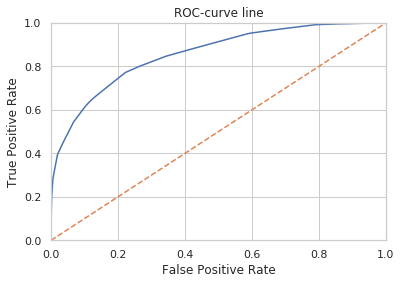

 auc_roc: 0.8560832506669492
accurate F1: 0.5386533665835411 
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      6370
           1       0.84      0.40      0.54      1630

    accuracy                           0.86      8000
   macro avg       0.85      0.69      0.73      8000
weighted avg       0.86      0.86      0.84      8000
 
 valid ROC-AUC: 


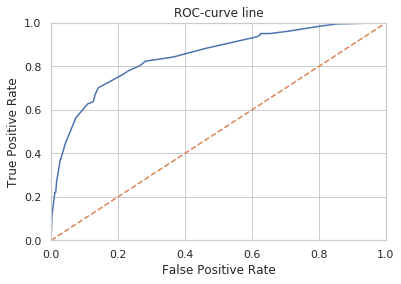

 auc_roc: 0.8464688639274804
accurate F1: 0.5016501650165016 
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       796
           1       0.77      0.37      0.50       204

    accuracy                           0.85      1000
   macro avg       0.81      0.67      0.71      1000
weighted avg       0.84      0.85      0.83      1000
 


In [32]:
print(bold_start,'train ROC-AUC:' ,bold_end)
roc_auc(dt, features_train_oe, target_train)

print(bold_start,'valid ROC-AUC:' ,bold_end )
roc_auc(dt, features_valid_oe, target_valid)

Также выведем общий репорт по точности, полноте и F1 мере.

**Вывод**       
Дерево решений достаточно хорошо обучилось на поиск отрицательных ответов, но с положительными возникла проблема из за недостатка данных для обучения.

- ### RandomForestClassifier():

In [33]:
param_grid_rf = {'max_depth': [deep for deep in range(2,11)],
                 'n_estimators': [20, 50, 100],
                 'random_state': [12345],
                 'min_samples_leaf':[leaf for leaf in range(1,10,1)]
                }
gs_rf = GridSearchCV(RandomForestClassifier(), param_grid = param_grid_rf)

In [34]:
gs_rf.fit(features_train_oe, target_train)
%time

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


In [35]:
gs_rf.best_params_

{'max_depth': 9,
 'min_samples_leaf': 7,
 'n_estimators': 20,
 'random_state': 12345}

In [36]:
rf = RandomForestClassifier(max_depth=gs_rf.best_params_['max_depth'],
                            min_samples_leaf=gs_rf.best_params_['min_samples_leaf'],
                            n_estimators=gs_rf.best_params_['n_estimators'],
                            random_state=12345)

rf.fit(features_train_oe, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

 train ROC-AUC: 


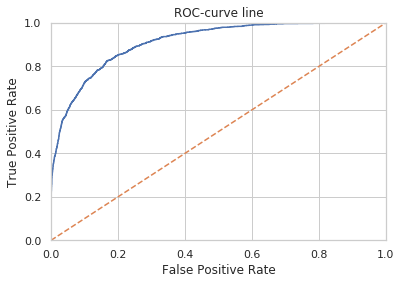

 auc_roc: 0.9121408827806724
accurate F1: 0.5801217038539553 
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      6370
           1       0.86      0.44      0.58      1630

    accuracy                           0.87      8000
   macro avg       0.86      0.71      0.75      8000
weighted avg       0.87      0.87      0.85      8000
 
 valid ROC-AUC: 


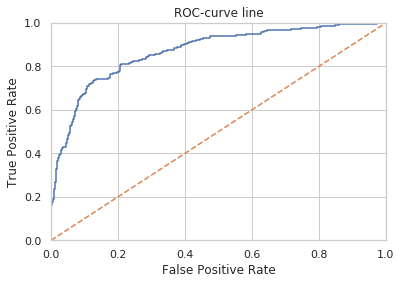

 auc_roc: 0.8692605182776627
accurate F1: 0.528052805280528 
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       796
           1       0.81      0.39      0.53       204

    accuracy                           0.86      1000
   macro avg       0.84      0.68      0.72      1000
weighted avg       0.85      0.86      0.84      1000
 


In [37]:
print(bold_start,'train ROC-AUC:' ,bold_end)
roc_auc(rf, features_train_oe, target_train)

print(bold_start,'valid ROC-AUC:' ,bold_end )
roc_auc(rf, features_valid_oe, target_valid)

**Вывод:**    
Ситуация аналогична предыдущему опыту, модель очень плохо определяет положительный класс.

- ### LogisticRegression():

In [38]:
param_grid_logres = {'penalty': ['l1','l2'],
                     'C': [0.5, 0.1],
                     'max_iter': [deep for deep in range(2,100)],
                     'random_state': [12345]}

gs_logres = GridSearchCV(LogisticRegression(), param_grid = param_grid_logres)

In [39]:
gs_logres.fit(features_train_ohe, target_train)
%time

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs


In [40]:
gs_logres.best_params_

{'C': 0.1, 'max_iter': 34, 'penalty': 'l1', 'random_state': 12345}

In [41]:
logres = LogisticRegression(C=gs_logres.best_params_['C'],
                            penalty=gs_logres.best_params_['penalty'],
                            max_iter = gs_logres.best_params_['max_iter'],
                            random_state=12345)

logres.fit(features_train_ohe, target_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=34,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=12345, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

 train ROC-AUC: 


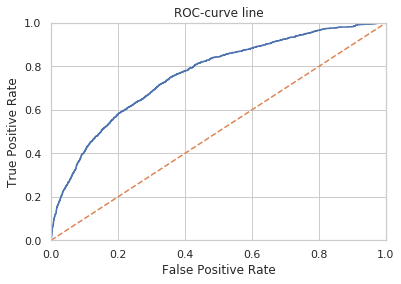

 auc_roc: 0.762352572931013
accurate F1: 0.3096118299445471 
               precision    recall  f1-score   support

           0       0.83      0.97      0.89      6370
           1       0.63      0.21      0.31      1630

    accuracy                           0.81      8000
   macro avg       0.73      0.59      0.60      8000
weighted avg       0.79      0.81      0.77      8000
 
 valid ROC-AUC: 


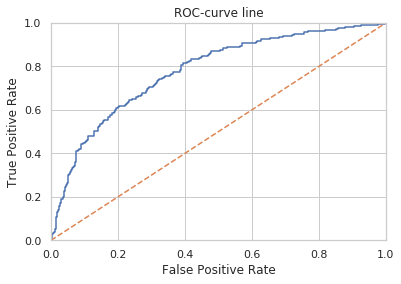

 auc_roc: 0.7777859887673663
accurate F1: 0.29104477611940294 
               precision    recall  f1-score   support

           0       0.82      0.97      0.89       796
           1       0.61      0.19      0.29       204

    accuracy                           0.81      1000
   macro avg       0.72      0.58      0.59      1000
weighted avg       0.78      0.81      0.77      1000
 


In [42]:
print(bold_start,'train ROC-AUC:' ,bold_end)
roc_auc(logres, features_train_ohe, target_train)

print(bold_start,'valid ROC-AUC:' ,bold_end )
roc_auc(logres, features_valid_ohe, target_valid)

**Вывод:**       
Логистическая регрессия справилась с определением положительного класса ещё хуже.

модели плохо обучены для положительного класса (1)

# 3. Борьба с дисбалансом

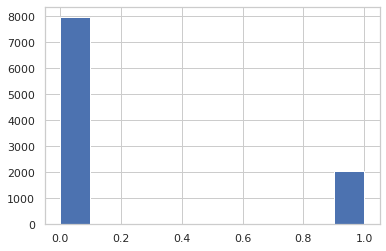

In [43]:
data.Exited.hist()

дисбаланс классов

In [44]:
ex_0 = data.query('Exited == 0')
ex_1 = data.query('Exited == 1')
# display(ex_0.head(5))
# display(ex_0.Exited.value_counts())
# display(ex_1.head(5))
# display(ex_1.Exited.value_counts())

In [45]:
ex_0_index = target_train[target_train == 0].index
ex_1_index = target_train[target_train != 0].index

ex_0 = data.loc[ex_0_index]
ex_1 = data.loc[ex_1_index]

# display(ex_0.head(5))
# display(ex_0.Exited.value_counts())

# display(ex_1.head(5))
# display(ex_1.Exited.value_counts())

In [46]:
differece = ex_0.shape[0] - ex_1.shape[0]
differece = int(differece)

сгенерируем недостающие элементы и добавим в нашe обучающую выборку

In [47]:
# DRY funcion for display shape, unique
def fisplay_function(X, Y):
    display(X.shape,
            Y.shape,
            np.unique(Y, return_counts=True))

In [48]:
up_data = ex_1.sample(differece, replace=True)#.drop(['Exited'], axis=1)
up_target_data = target_train.loc[up_data.index]

features_upsampling_train = pd.concat([features_train, up_data])
features_upsampling_train = shuffle(features_upsampling_train, random_state=12345)
target_upsampling_train =features_upsampling_train['Exited'] 
#target_upsampling_train = np.hstack((target_train.values, up_target_data.values))

#############
# _display_ #
#############
fisplay_function(features_upsampling_train,
                 target_upsampling_train)

(12740, 14)

(12740,)

(array([ 1., nan, nan, ..., nan, nan, nan]),
 array([4740,    1,    1, ...,    1,    1,    1]))

In [49]:
up_data = ex_1.sample(differece, replace=True).drop(['Exited'], axis=1)
up_target_data = target_train.loc[up_data.index]

features_upsampling_train = pd.concat([features_train, up_data])
target_upsampling_train = np.hstack((target_train.values, up_target_data.values))

features_upsampling_train, target_upsampling_train = shuffle(features_upsampling_train, target_upsampling_train,
                                                             random_state=12345)

#############
# _display_ #
#############
fisplay_function(features_upsampling_train,
                 target_upsampling_train)

(12740, 13)

(12740,)

(array([0, 1]), array([6370, 6370]))

---

In [50]:
down_data = ex_0.sample(ex_1.shape[0], replace=False) # мы генерируем 0 столько же сколько кол-во 1
down_target_data =  target_train.loc[down_data.index] # достаем их по индексу из корневого списка

features_downsampling_train = pd.concat([ex_1, down_data]) # добавили в список из 1
target_downsampling_train = np.hstack((target_train[target_train !=0].values, down_target_data.values))

features_downsampling_train, target_downsampling_train = shuffle(features_downsampling_train, target_downsampling_train,
                                                                 random_state=12345)


#############
# _display_ #
#############
fisplay_function(features_downsampling_train,
               target_downsampling_train)

(3260, 14)

(3260,)

(array([0, 1]), array([1630, 1630]))

Повторно для удобста вразделяем списки для разных моделей


In [51]:
features_downsampling_train = features_downsampling_train.drop(['Exited'], axis=1)

In [52]:
features_upsampling_train_ohe = features_upsampling_train.drop(['Geography'], axis=1)
features_upsampling_train_oe = features_upsampling_train.drop(['Spain','France','Germany'], axis=1)

In [53]:
features_downsampling_train_ohe = features_downsampling_train.drop(['Geography'], axis=1)
features_downsampling_train_oe = features_downsampling_train.drop(['Spain','France','Germany'], axis=1)

# Обучим модель на сбалансированных данных:

- ## LogisticRegression():

### for upsampling

In [54]:
param_grid_logres = {'penalty': ['l1','l2'],
                     'C': [0.5, 0.1],
                     'max_iter': [deep for deep in range(2,100)],
                     'random_state': [12345],
                     'class_weight': ['balanced']}

gs_logres = GridSearchCV(LogisticRegression(), param_grid = param_grid_logres)

In [55]:
gs_logres.fit(features_upsampling_train_ohe, target_upsampling_train)
%time

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.7 µs


In [56]:
gs_logres.best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 18,
 'penalty': 'l1',
 'random_state': 12345}

In [57]:
logres = LogisticRegression(C=gs_logres.best_params_['C'],
                            penalty=gs_logres.best_params_['penalty'],
                            max_iter = gs_logres.best_params_['max_iter'],
                            class_weight ='balanced',
                            random_state=12345)

logres.fit(features_upsampling_train_ohe, target_upsampling_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=18, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=12345, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

 train ROC-AUC: 


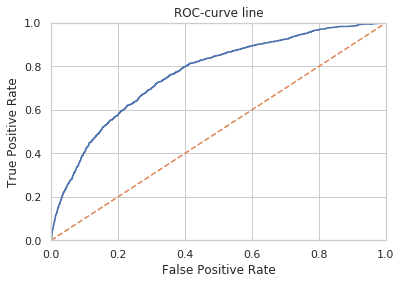

 auc_roc: 0.7669993272034088
accurate F1: 0.6981386138613862 
               precision    recall  f1-score   support

           0       0.70      0.71      0.70      6370
           1       0.70      0.69      0.70      6370

    accuracy                           0.70     12740
   macro avg       0.70      0.70      0.70     12740
weighted avg       0.70      0.70      0.70     12740
 
 valid ROC-AUC: 


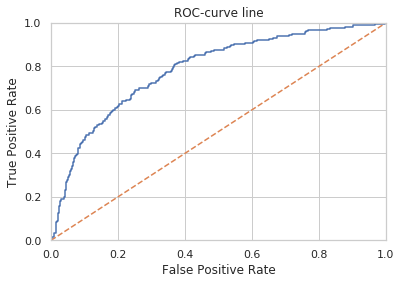

 auc_roc: 0.7848741255296087
accurate F1: 0.5017064846416383 
               precision    recall  f1-score   support

           0       0.91      0.70      0.79       796
           1       0.38      0.72      0.50       204

    accuracy                           0.71      1000
   macro avg       0.65      0.71      0.65      1000
weighted avg       0.80      0.71      0.73      1000
 


In [58]:
print(bold_start,'train ROC-AUC:' ,bold_end)
roc_auc(logres, features_upsampling_train_ohe, target_upsampling_train)

print(bold_start,'valid ROC-AUC:' ,bold_end )
roc_auc(logres, features_valid_ohe, target_valid)

#### for downsampling

In [59]:
param_grid_logres = {'penalty': ['l1','l2'],
                     'C': [0.5, 0.1],
                     'max_iter': [deep for deep in range(2,100)],
                     'random_state': [12345],
                     'class_weight': ['balanced']}

gs_logres = GridSearchCV(LogisticRegression(), param_grid = param_grid_logres)

In [60]:
gs_logres.fit(features_downsampling_train_ohe, target_downsampling_train)
%time

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


In [61]:
gs_logres.best_params_

{'C': 0.5,
 'class_weight': 'balanced',
 'max_iter': 19,
 'penalty': 'l1',
 'random_state': 12345}

In [62]:
logres = LogisticRegression(C=gs_logres.best_params_['C'],
                            penalty=gs_logres.best_params_['penalty'],
                            max_iter = gs_logres.best_params_['max_iter'],
                            class_weight ='balanced',
                            random_state=12345)

logres.fit(features_downsampling_train_ohe, target_downsampling_train)

LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=19, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=12345, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

 train ROC-AUC: 


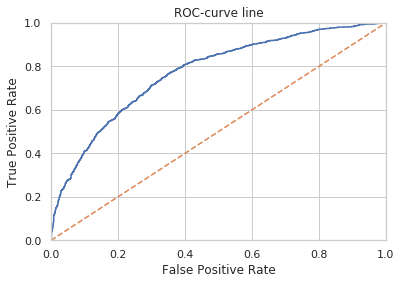

 auc_roc: 0.7714513154428092
accurate F1: 0.6997840172786177 
               precision    recall  f1-score   support

           0       0.70      0.71      0.70      1630
           1       0.70      0.70      0.70      1630

    accuracy                           0.70      3260
   macro avg       0.70      0.70      0.70      3260
weighted avg       0.70      0.70      0.70      3260
 
 valid ROC-AUC: 


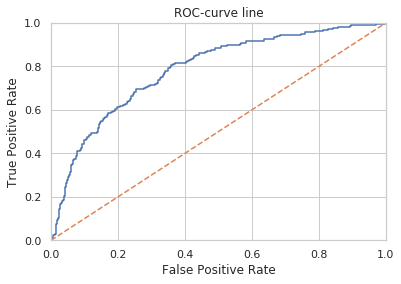

 auc_roc: 0.7839195979899497
accurate F1: 0.494077834179357 
               precision    recall  f1-score   support

           0       0.91      0.70      0.79       796
           1       0.38      0.72      0.49       204

    accuracy                           0.70      1000
   macro avg       0.64      0.71      0.64      1000
weighted avg       0.80      0.70      0.73      1000
 


In [63]:
print(bold_start,'train ROC-AUC:' ,bold_end)
roc_auc(logres, features_downsampling_train_ohe, target_downsampling_train)

print(bold_start,'valid ROC-AUC:' ,bold_end )
roc_auc(logres, features_valid_ohe, target_valid)

- # RandomForestClassifier():

##  for upsampling

In [64]:
param_grid_rf = {'max_depth': [deep for deep in range(2,11)],
                 'n_estimators': [20, 50, 100],
                 'random_state': [12345],
                 'min_samples_leaf':[leaf for leaf in range(1,10,1)],
                 'class_weight': ['balanced']
                }
gs_rf = GridSearchCV(RandomForestClassifier(), param_grid = param_grid_rf)

In [65]:
gs_rf.fit(features_upsampling_train_oe, target_upsampling_train)
%time

CPU times: user 16 µs, sys: 4 µs, total: 20 µs
Wall time: 24.1 µs


In [66]:
gs_rf.best_params_

{'class_weight': 'balanced',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'n_estimators': 100,
 'random_state': 12345}

In [67]:
rf = RandomForestClassifier(max_depth=gs_rf.best_params_['max_depth'],
                            min_samples_leaf=gs_rf.best_params_['min_samples_leaf'],
                            n_estimators=gs_rf.best_params_['n_estimators'],
                            class_weight ='balanced',
                            random_state=12345)

rf.fit(features_upsampling_train_oe, target_upsampling_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

 train ROC-AUC: 


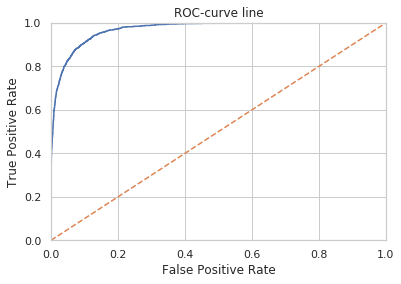

 auc_roc: 0.9707813805391737
accurate F1: 0.9037071944706252 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      6370
           1       0.90      0.90      0.90      6370

    accuracy                           0.90     12740
   macro avg       0.90      0.90      0.90     12740
weighted avg       0.90      0.90      0.90     12740
 
 valid ROC-AUC: 


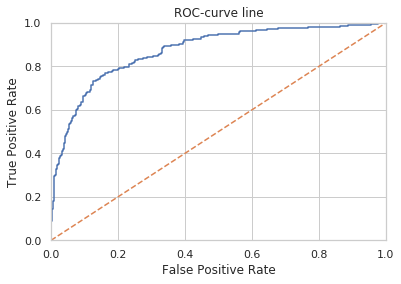

 auc_roc: 0.8722718987092325
accurate F1: 0.6507592190889371 
               precision    recall  f1-score   support

           0       0.93      0.87      0.90       796
           1       0.58      0.74      0.65       204

    accuracy                           0.84      1000
   macro avg       0.76      0.80      0.77      1000
weighted avg       0.86      0.84      0.85      1000
 


In [68]:
print(bold_start,'train ROC-AUC:' ,bold_end)
roc_auc(rf, features_upsampling_train_oe, target_upsampling_train)

print(bold_start,'valid ROC-AUC:' ,bold_end )
roc_auc(rf, features_valid_oe, target_valid)

### Эта модель пока самая лучшая, запишем ее данные чтобы потом проверить 

In [69]:
bestP = gs_rf.best_params_

In [70]:
best_model =  RandomForestClassifier(max_depth=gs_rf.best_params_['max_depth'],
                                     min_samples_leaf=gs_rf.best_params_['min_samples_leaf'],
                                     n_estimators=gs_rf.best_params_['n_estimators'],
                                     class_weight ='balanced',
                                     random_state=12345)

## for downsampling

In [71]:
param_grid_rf = {'max_depth': [deep for deep in range(2,11)],
                 'n_estimators': [20, 50, 100],
                 'random_state': [12345],
                 'min_samples_leaf':[leaf for leaf in range(1,10,1)],
                 'class_weight': ['balanced']
                }
gs_rf = GridSearchCV(RandomForestClassifier(), param_grid = param_grid_rf)

In [72]:
gs_rf.fit(features_downsampling_train_oe, target_downsampling_train)
%time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


In [73]:
gs_rf.best_params_

{'class_weight': 'balanced',
 'max_depth': 9,
 'min_samples_leaf': 2,
 'n_estimators': 100,
 'random_state': 12345}

In [74]:
rf = RandomForestClassifier(max_depth=gs_rf.best_params_['max_depth'],
                            min_samples_leaf=gs_rf.best_params_['min_samples_leaf'],
                            n_estimators=gs_rf.best_params_['n_estimators'],
                            class_weight ='balanced',
                            random_state=12345)

rf.fit(features_downsampling_train_oe, target_downsampling_train)

predictions_rf_train = rf.predict(features_downsampling_train_oe)
predictions_rf_valid = rf.predict(features_valid_oe)

 train ROC-AUC: 


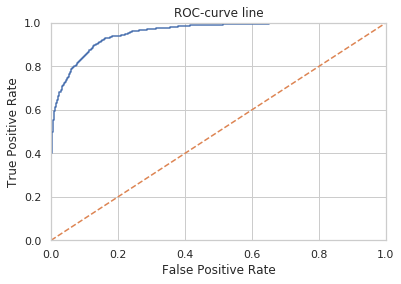

 auc_roc: 0.9553103240618765
accurate F1: 0.869757174392936 
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      1630
           1       0.89      0.85      0.87      1630

    accuracy                           0.87      3260
   macro avg       0.87      0.87      0.87      3260
weighted avg       0.87      0.87      0.87      3260
 
 valid ROC-AUC: 


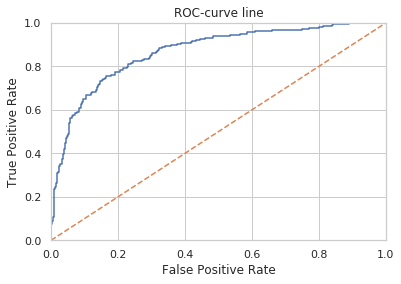

 auc_roc: 0.8665201005025125
accurate F1: 0.6088631984585743 
               precision    recall  f1-score   support

           0       0.93      0.80      0.86       796
           1       0.50      0.77      0.61       204

    accuracy                           0.80      1000
   macro avg       0.72      0.79      0.74      1000
weighted avg       0.84      0.80      0.81      1000
 


In [75]:
print(bold_start,'train ROC-AUC:' ,bold_end)
roc_auc(rf, features_downsampling_train_oe, target_downsampling_train)

print(bold_start,'valid ROC-AUC:' ,bold_end )
roc_auc(rf, features_valid_oe, target_valid)

---

* ### DecisionTreeClassifier():

капипаст - зло (

#### for upsampling

In [76]:
param_grid_dt = {'max_depth':[depth for depth in range(1,15)],
                 'min_samples_split':[split for split in range(2,10,1)],
                 'min_samples_leaf':[leaf for leaf in range(1,10,1)],
                 'random_state': [12345],
                 'class_weight': ['balanced']
                }
gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid = param_grid_dt)

In [77]:
gs_dt.fit(features_upsampling_train_oe, target_upsampling_train)
%time

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


In [78]:
gs_dt.best_params_

{'class_weight': 'balanced',
 'max_depth': 14,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 12345}

In [79]:
dt = DecisionTreeClassifier(max_depth =gs_dt.best_params_['max_depth'], 
                            min_samples_leaf =gs_dt.best_params_['min_samples_leaf'],
                            min_samples_split = gs_dt.best_params_['min_samples_split'],
                            class_weight ='balanced',
                            random_state=12345)
dt.fit(features_upsampling_train_oe, target_upsampling_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=14,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

 train ROC-AUC: 


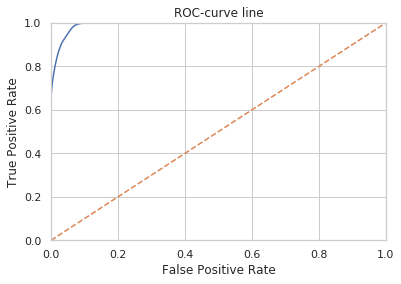

 auc_roc: 0.9921461718366854
accurate F1: 0.9597008090367882 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      6370
           1       0.93      0.99      0.96      6370

    accuracy                           0.96     12740
   macro avg       0.96      0.96      0.96     12740
weighted avg       0.96      0.96      0.96     12740
 
 valid ROC-AUC: 


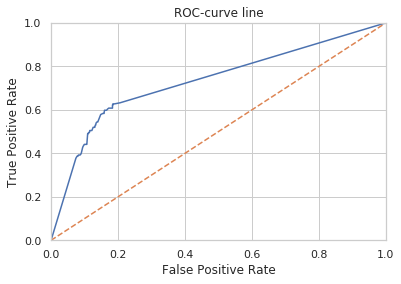

 auc_roc: 0.7323258449108286
accurate F1: 0.5327510917030568 
               precision    recall  f1-score   support

           0       0.89      0.83      0.86       796
           1       0.48      0.60      0.53       204

    accuracy                           0.79      1000
   macro avg       0.69      0.72      0.70      1000
weighted avg       0.81      0.79      0.79      1000
 


In [80]:
print(bold_start,'train ROC-AUC:' ,bold_end)
roc_auc(dt, features_upsampling_train_oe, target_upsampling_train)

print(bold_start,'valid ROC-AUC:' ,bold_end )
roc_auc(dt, features_valid_oe, target_valid)

#### for downsampling

In [81]:
param_grid_dt = {'max_depth':[depth for depth in range(1,15)],
                 'min_samples_split':[split for split in range(2,10,1)],
                 'min_samples_leaf':[leaf for leaf in range(1,10,1)],
                 'random_state': [12345],
                 'class_weight': ['balanced']
                }
gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid = param_grid_dt)

In [82]:
gs_dt.fit(features_downsampling_train_oe, target_downsampling_train)
%time

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.34 µs


In [83]:
dt = DecisionTreeClassifier(max_depth =gs_dt.best_params_['max_depth'], 
                            min_samples_leaf =gs_dt.best_params_['min_samples_leaf'],
                            min_samples_split = gs_dt.best_params_['min_samples_split'],
                            class_weight ='balanced',
                            random_state=12345)
dt.fit(features_downsampling_train_oe, target_downsampling_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

 train ROC-AUC: 


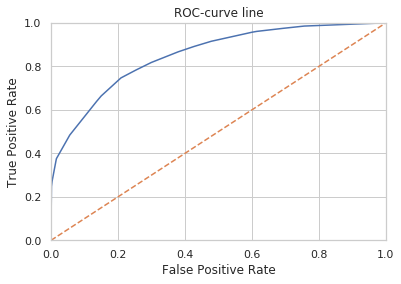

 auc_roc: 0.85186439083142
accurate F1: 0.7637276435519298 
               precision    recall  f1-score   support

           0       0.76      0.79      0.77      1630
           1       0.78      0.75      0.76      1630

    accuracy                           0.77      3260
   macro avg       0.77      0.77      0.77      3260
weighted avg       0.77      0.77      0.77      3260
 
 valid ROC-AUC: 


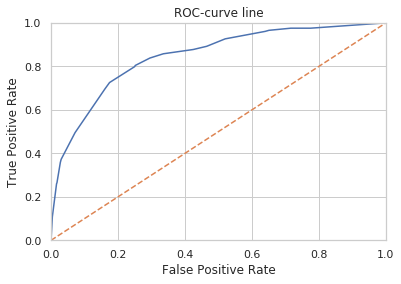

 auc_roc: 0.8463333825992707
accurate F1: 0.5759717314487633 
               precision    recall  f1-score   support

           0       0.94      0.75      0.83       796
           1       0.45      0.80      0.58       204

    accuracy                           0.76      1000
   macro avg       0.69      0.77      0.70      1000
weighted avg       0.84      0.76      0.78      1000
 


In [84]:
print(bold_start,'train ROC-AUC:' ,bold_end)
roc_auc(dt, features_downsampling_train_oe, target_downsampling_train)

print(bold_start,'valid ROC-AUC:' ,bold_end )
roc_auc(dt, features_valid_oe, target_valid)

# 4. Тестирование модели

In [85]:
target_valid.value_counts()

0    796
1    204
Name: Exited, dtype: int64

In [86]:
best_model.fit(features_train_oe, target_train)
prediction =  best_model.predict(features_test_oe)

score_best_model = best_model.score(features_test_oe, target_test)

print(f1_score(target_test, prediction))

0.6187050359712231


Наконец то, добились нужного результата!

# Общий вывод:

- По результатам предсказаний самой лучшей модели *20,4%* клиентов тестовой выборки откажутся от услуг банка.
- **F1-мера** — среднее гармоническое precision и recall: получившее значение *0.6187*, говорит о плохом соотношении классов, что влияет на предсказания модели. Метод повторной дискретизации позволил увеличить значение F1-меры, но для получения лучших результатов предсказаний необходимо пополнить базу оттока клиентов.